In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
import gc
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from feature_selector import FeatureSelector


import time
import datetime
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt 
import seaborn as sns 

from feature_selector import FeatureSelector
%matplotlib inline


In [2]:
train = pd.read_csv("train.csv")
test =pd.read_csv("test.csv")

del_cols = []
for col in train.columns:
    if 'subsector_id_cnt_' in col and 'new_cardf': 
        del_cols.append(col)
del_cols1 = []
for col in train.columns:
    if 'subsector_id_cnt_' in col and 'hist_last2_' in col:
        del_cols1.append(col)
del_cols2 = []
for col in train.columns:
    if 'subsector_id_cnt_' in col and 'auth_cardf' in col:
        del_cols2.append(col)
del_cols3 = []
for col in train.columns:
    if 'merchant_category_id_month_lag_nunique_' in col and '_pivot_supp' in col:
        del_cols3.append(col)
    if 'city_id' in col and '_pivot_supp' in col:
        del_cols3.append(col)
    if 'month_diff' in col and 'hist_last2_' in col:
        del_cols3.append(col)
    if 'month_diff_std' in col or 'month_diff_gap' in col:
        del_cols3.append(col) 
fea_cols = [col for col in train.columns if train[col].dtypes!='object' and train[col].dtypes != '<M8[ns]' and col!='target' not in col and col!='min_num'\
            and col not in del_cols and col not in del_cols1 and col not in del_cols2 and col!='target1' and col!='card_id_cnt_ht_pivot_supp'  and col not in del_cols3] 

train = train[fea_cols+['target']]
cardids = train['card_id']
fea_cols.remove('outliers')
test = test[fea_cols]

In [3]:
train_labels = train['target'].values
del train['target']
fs = FeatureSelector(data = train, labels = train_labels)


Identify features with missing values >60%

In [4]:
fs.identify_missing(missing_threshold=0.6)


4 features with greater than 0.60 missing values.



In [5]:
missing_features = fs.ops['missing']
missing_features[:10]

['new_cardf_card_id_part_cnt',
 'new_cardf_card_id_part_purchase_amount_sum',
 'new_cardf_card_id_part_purchase_amount_mean',
 'new_cardf_card_id_part_purchase_amount_sum_percent']

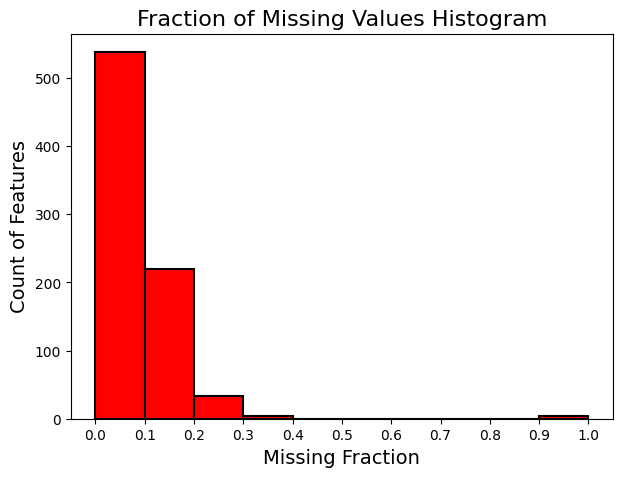

In [6]:
fs.plot_missing()


In [7]:
fs.missing_stats

,missing_fraction
new_cardf_card_id_part_purchase_amount_sum_percent,1.000000
new_cardf_card_id_part_purchase_amount_mean,1.000000
new_cardf_card_id_part_purchase_amount_sum,1.000000
new_cardf_card_id_part_cnt,1.000000
new_amount_month_ratio_skew,0.355933
...,...
hist_cardf_card_id_month_lag_nunique,0.000000
hist_cardf_card_id_cnt_divide_month_lag_nunique,0.000000
hist_cardf_card_id_purchase_date_floorday_nunique,0.000000
hist_cardf_card_id_cnt_divide_purchase_date_floorday_nunique,0.000000


Zero Importance Features


In [8]:
fs.identify_zero_importance(task = 'regression', eval_metric = 'auc', 
                            n_iterations = 5, early_stopping = True)

Training Gradient Boosting Model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.056838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149245
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 795
[LightGBM] [Info] Start training from score -0.396133
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.689086	valid_0's l2: 2.40257
[400]	valid_0's auc: 0.689142	valid_0's l2: 2.4051
[600]	valid_0's auc: 0.688615	valid_0's l2: 2.40852
Early stopping, best iteration is:
[177]	valid_0's auc: 0.68915	valid_0's l2: 2.40178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.116279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149151
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 795
[LightGBM] [Info] Start

In [9]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 799 original features
There are 0 one-hot features


In [10]:
fs.data_all.head(10)


,Unnamed: 0,feature_1,feature_2,feature_3,year,elapsed_time,weekofyear,dayofyear,month,auth_category_1_mean,...,purchase_amount_ratio_v3,purchase_amount_diff_sum,purchase_amount_diff_mean,purchase_amount_diff_max,purchase_amount_diff_min,pa_mlag_ratio,pa_new_hist_ratio,pa_new_hist_mean_ratio,pa_new_hist_min_ratio,pa_new_hist_max_ratio
0,0,5,2,1,2017,273,22,152,6,0.000000,...,0.396301,1860.0,55.551838,90.0,9.0,-479.169014,3.457067,1.953995,2.500000,1.428572
1,1,4,1,0,2017,424,52,1,1,0.085546,...,0.006356,-4636.0,-415.090900,-1760.0,1.0,-15.400000,0.017797,0.032627,1.250000,0.016760
2,2,2,2,0,2016,577,31,214,8,0.000000,...,0.300971,-72.0,-20.500000,-42.0,1.0,-2.583333,0.300971,0.601942,1.033333,0.424658
3,3,4,3,0,2017,181,35,244,9,0.155844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,3,0,2017,120,44,305,11,0.093750,...,0.049716,-11397.0,-3077.477800,-4487.0,-151.0,-3310.000000,0.289065,0.040148,0.032051,0.150833
5,5,4,2,0,2016,546,35,245,9,0.031250,...,5.522222,966.0,174.000000,407.0,-29.0,-528.000000,11.733334,2.933333,0.677778,5.522222
6,6,3,2,1,2016,455,48,336,12,0.000000,...,0.133106,-205.0,0.364706,-7.0,-2.0,-10.108108,0.300341,1.021160,0.600000,0.847826
7,7,3,2,1,2017,181,35,244,9,0.000000,...,0.253846,-35.0,-11.666666,-32.0,29.0,-31.666667,0.730769,0.730769,30.000000,0.507692
8,8,2,1,0,2017,212,31,213,8,0.000000,...,inf,154.0,77.000000,111.0,43.0,-25.666667,inf,inf,inf,inf
9,9,2,2,0,2016,577,31,214,8,0.000000,...,0.048301,-1051.0,-57.523804,-158.0,-6.0,-12.506667,0.059928,0.279666,0.333333,0.254717


In [11]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features[10:15]

['hist_cardf_subsector_id_day_nunique_pct_28',
 'month',
 'auth_cardf_card_id_cnt',
 'feature_mean',
 'card_id_cnt_total']

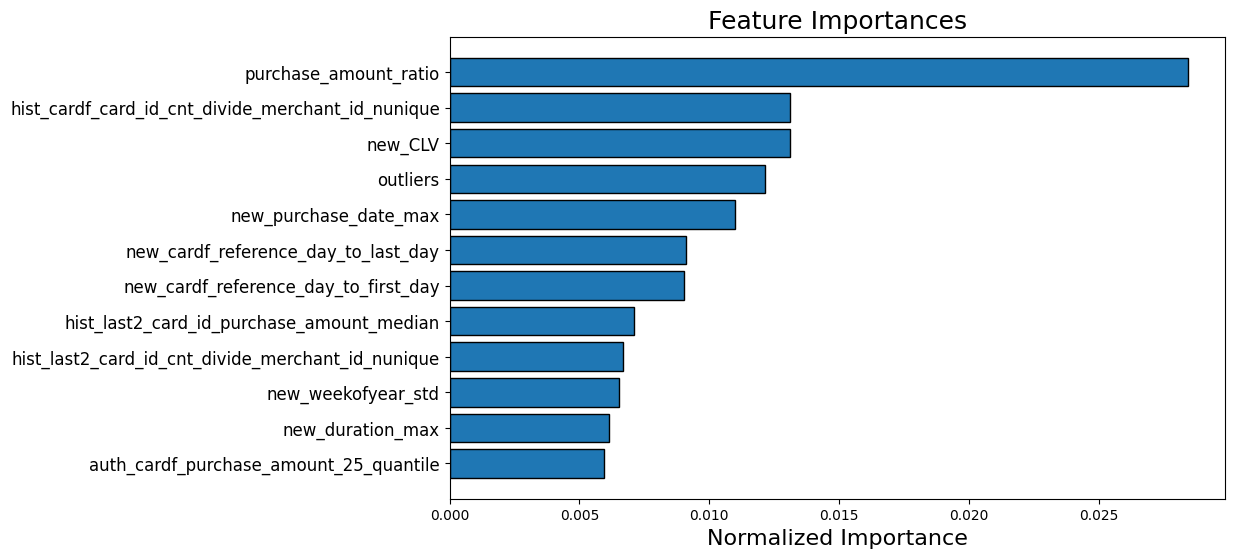

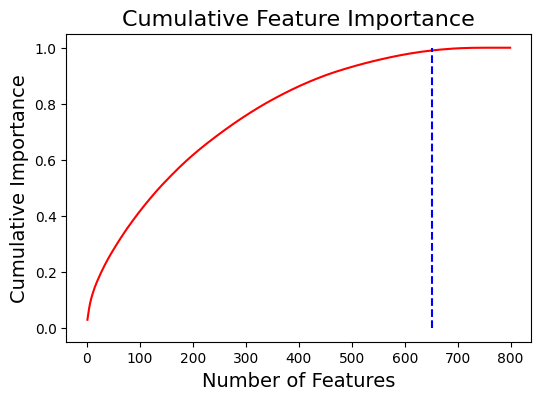

651 features required for 0.99 of cumulative importance


In [12]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [13]:
fs.feature_importances.head(10)


,feature,importance,normalized_importance,cumulative_importance
0,purchase_amount_ratio,259.0,0.028418,0.028418
1,hist_cardf_card_id_cnt_divide_merchant_id_nunique,119.5,0.013112,0.041530
2,new_CLV,119.3,0.013090,0.054619
3,outliers,110.7,0.012146,0.066765
4,new_purchase_date_max,100.2,0.010994,0.077759
5,new_cardf_reference_day_to_last_day,83.0,0.009107,0.086866
6,new_cardf_reference_day_to_first_day,82.1,0.009008,0.095874
7,hist_last2_card_id_purchase_amount_median,64.8,0.007110,0.102984
8,hist_last2_card_id_cnt_divide_merchant_id_nunique,61.0,0.006693,0.109677
9,new_weekofyear_std,59.3,0.006506,0.116184


In [14]:
one_hundred_features = list(fs.feature_importances.loc[:99, 'feature'])
len(one_hundred_features)

100

Low Importance Features

In [15]:
fs.identify_low_importance(cumulative_importance = 0.99)


650 features required for cumulative importance of 0.99 after one hot encoding.
149 features do not contribute to cumulative importance of 0.99.



In [16]:
low_importance_features = fs.ops['low_importance']
low_importance_features[:5]

['new_cardf_subsector_id_day_nunique_pct_35',
 'hist_cardf_card_id_month_lag_min',
 'hist_cardf_month_lag_cnt_pivot_-10',
 'hist_levelAB_purchase_date_floorday_merchant_id_nunique_max',
 'new_cardf_subsector_id_day_nunique_pct_18']

Remove Variables

In [17]:
train_no_missing = fs.remove(methods = ['missing'])


Removed 4 features.


In [18]:
train_no_missing_zero = fs.remove(methods = ['missing', 'zero_importance'])


Removed 52 features.


In [19]:
all_to_remove = fs.check_removal()

Total of 149 features identified for removal


In [20]:
all_to_remove[1:25]


['auth_cardf_card_id_month_lag_nunique',
 'hist_last2_subsector_id_day_nunique_pct_-1',
 'auth_cardf_category_2_cnt_pivot_4.0',
 'new_cardf_subsector_id_day_nunique_pct_12',
 'new_year_nunique',
 'new_card_id_count',
 'hist_cardf_card_id_month_lag_min',
 'auth_card_id_count',
 'hist_levelAB_merchant_id_count_mean',
 'new_cardf_card_id_cnt_divide_merchant_id_nunique',
 'new_cardf_subsector_id_day_nunique_pct_30',
 'auth_cardf_card_id_purchase_amount_max',
 'new_cardf_card_id_category_1_nunique',
 'hist_card_id_count',
 'new_cardf_subsector_id_day_nunique_pct_9',
 'new_installments_min',
 'auth_cardf_month_lag_cnt_pivot_-13',
 'auth_cardf_card_id_category_1_nunique',
 'feature_3',
 'new_cardf_subsector_id_day_nunique_pct_10',
 'auth_cardf_subsector_id_day_nunique_pct_4',
 'hist_levelAB_merchant_category_id_count_mean',
 'new_cardf_subsector_id_day_nunique_pct_26',
 'new_cardf_card_id_purchase_amount_mean']

In [21]:
train = train.drop(columns=all_to_remove)
test = test.drop(columns=all_to_remove)

In [22]:
train['target'] = train_labels
train['card_id'] = cardids

/var/folders/tp/twg0lnts57q27bccjryrlk2w0000gn/T/ipykernel_19000/823882552.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['target'] = train_labels


In [23]:
train.to_csv("train_cleaned.csv")

In [24]:
test.to_csv("test_cleaned.csv")